<a href="https://colab.research.google.com/github/Aipakazuma/meetup037/blob/master/002_%E3%83%8F%E3%82%A4%E3%83%91%E3%83%BC%E3%83%91%E3%83%A9%E3%83%A1%E3%83%BC%E3%82%BF%E3%81%AE%E3%83%81%E3%83%A5%E3%83%BC%E3%83%8B%E3%83%B3%E3%82%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ハイパーパラメータのチューニング

ここでは、精度向上を進めながら、パラメータの選定方法であったり、チューニングの参考例をハンズオンで行う


## やること

* 機械学習の目的と課題
* 学習不足と過学習の確認
* 過学習を抑えるためのtips
  * l2正則化
  * Dropout
  * BatchNormalization
* 自分で組んでみたモデルがどれくらい自信をもって予測しているのかを調べる

## 必要なモジュールのimport

In [3]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.utils import to_categorical
from keras.datasets import cifar10


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [0]:
# label名
label_names = ['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

# データの用意
(X_train, _y_train), (X_test, _y_test) = cifar10.load_data()

# 前処理
# 画像を0-1の範囲で正規化
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# 正解ラベルをOne-Hot表現に変換
y_train = to_categorical(_y_train, 10)
y_test = to_categorical(_y_test, 10)

# 訓練データ全体を使って学習する回数
epochs = 20

# 一度に学習するデータの数
batch_size = 128

## 機械学習の目的と課題

* 目的は、ある訓練データを元に学習したモデルが未知のデータに対しても予測できるようになること
* そのため、訓練データに対しての精度向上をがんばるのではなく、訓練データ以外の新しいデータ（テストデータ）に対しても精度が良くなるよう調整する（汎化させる）必要がある
* 例えば、mnistの訓練データ50000を100%学習させるのであれば、ディープラーニングのパラメータを50000 * 10(0~9) = 500000のパラメータがあれば良い。しかし、新しいデータを入力した場合はそういうモデルはうまくあてることができません
* なので、汎化性能をあげれるようがんばりましょう
* 汎化性能をあげる最善策は訓練データを増やすこと。いろんなデータを増やすことで自然に汎化していきますが、データを集めるコストは結構高い
* そのため、他の手で汎化性能を上げる方法を試してみましょう

### 学習不足

* パラメータが多いと単純に訓練に時間がかかります
* そのため、パラメータを削減するアプローチを取りますが、削減しすぎるとこれまたうまくいかないことがあります
* 問題に対し、パラメータ数が十分で、学習不足にならないようにする必要があります

In [0]:
model = Sequential()
model.add(Flatten(input_shape=(32,32,3)))
model.add(Dense(5))
model.add(Activation('relu'))

model.add(Dense(5))
model.add(Activation('relu'))

model.add(Dense(10))
model.add(Activation('softmax'))

model.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])

In [22]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 5)                 15365     
_________________________________________________________________
activation_10 (Activation)   (None, 5)                 0         
_________________________________________________________________
dense_11 (Dense)             (None, 5)                 30        
_________________________________________________________________
activation_11 (Activation)   (None, 5)                 0         
_________________________________________________________________
dense_12 (Dense)             (None, 10)                60        
_________________________________________________________________
activation_12 (Activation)   (None, 10)                0         
Total para

In [23]:
# モデルのfitting
history = model.fit(X_train,
                    y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_split=0.1)  # validation_split -> 訓練の最後の10%を検証データとする

Train on 45000 samples, validate on 5000 samples
Epoch 1/20
45000/45000 [==============================] - 5s 105us/step - loss: 2.3029 - acc: 0.0970 - val_loss: 2.3027 - val_acc: 0.0950
Epoch 2/20
45000/45000 [==============================] - 4s 97us/step - loss: 2.3027 - acc: 0.0981 - val_loss: 2.3028 - val_acc: 0.0958
Epoch 3/20
45000/45000 [==============================] - 4s 93us/step - loss: 2.3027 - acc: 0.0987 - val_loss: 2.3028 - val_acc: 0.0958
Epoch 4/20
45000/45000 [==============================] - 4s 81us/step - loss: 2.3027 - acc: 0.0989 - val_loss: 2.3028 - val_acc: 0.0950
Epoch 5/20
45000/45000 [==============================] - 4s 98us/step - loss: 2.3027 - acc: 0.0960 - val_loss: 2.3028 - val_acc: 0.0986
Epoch 6/20
45000/45000 [==============================] - 4s 98us/step - loss: 2.3027 - acc: 0.0971 - val_loss: 2.3028 - val_acc: 0.0950
Epoch 7/20
45000/45000 [==============================] - 4s 94us/step - loss: 2.3027 - acc: 0.0970 - val_loss: 2.3029 - val_acc

In [24]:
# テストデータの精度を確認する
loss, acc = model.evaluate(X_test, y_test)
print('test loss: {}, test acc: {}'.format(loss, acc))

10000/10000 [==============================] - 1s 96us/step
test loss: 2.3026068809509277, test acc: 0.1


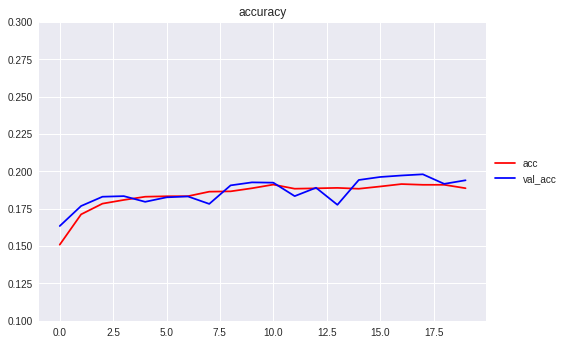

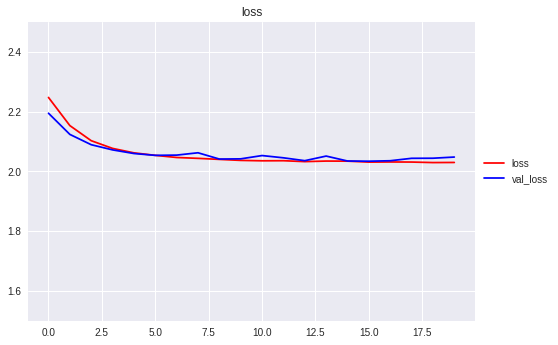

In [13]:
x = range(epochs)
plt.plot(x, history.history['acc'], label='acc', color='r')
plt.plot(x, history.history['val_acc'], label='val_acc', color='b')
plt.ylim(0.1, 0.3)
plt.title('accuracy')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.plot(x, history.history['loss'], label='loss', color='r')
plt.plot(x, history.history['val_loss'], label='val_loss', color='b')
plt.title('loss')
plt.ylim(1.5, 2.5)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

* 最初に行ったチュートリアルの結果図と比較すると全く学習できていないことがわかる

### 過学習

* パラメータ数が多すぎ、レイヤー数が多すぎ
* 訓練データに最適化されすぎのため、テストデータの予測がうまくいかない
* なにも考えず、重みを持つレイヤーだけで攻めると簡単に陥ってしまうため、いくつか回避できるかもしれない方法があります(後半でやります)

In [0]:
model = Sequential()
model.add(Flatten(input_shape=(32,32,3)))
model.add(Dense(2500))
model.add(Activation('relu'))

model.add(Dense(3000))
model.add(Activation('relu'))

model.add(Dense(10))
model.add(Activation('softmax'))

model.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])

In [17]:
# モデルのfitting
history = model.fit(X_train,
                    y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_split=0.1)  # validation_split -> 訓練の最後の10%を検証データとする

Train on 45000 samples, validate on 5000 samples
Epoch 1/20
45000/45000 [==============================] - 13s 288us/step - loss: 2.0109 - acc: 0.3205 - val_loss: 1.7635 - val_acc: 0.3724
Epoch 2/20
45000/45000 [==============================] - 11s 254us/step - loss: 1.6683 - acc: 0.4035 - val_loss: 1.6409 - val_acc: 0.4178
Epoch 3/20
45000/45000 [==============================] - 11s 236us/step - loss: 1.5897 - acc: 0.4324 - val_loss: 1.6002 - val_acc: 0.4332
Epoch 4/20
45000/45000 [==============================] - 11s 234us/step - loss: 1.5413 - acc: 0.4470 - val_loss: 1.5390 - val_acc: 0.4544
Epoch 5/20
45000/45000 [==============================] - 12s 257us/step - loss: 1.5002 - acc: 0.4607 - val_loss: 1.5059 - val_acc: 0.4730
Epoch 6/20
45000/45000 [==============================] - 11s 252us/step - loss: 1.4591 - acc: 0.4805 - val_loss: 1.4860 - val_acc: 0.4758
Epoch 7/20
45000/45000 [==============================] - 11s 250us/step - loss: 1.4309 - acc: 0.4877 - val_loss: 1.4

In [20]:
# テストデータの精度を確認する
loss, acc = model.evaluate(X_test, y_test)
print('test loss: {}, test acc: {}'.format(loss, acc))

10000/10000 [==============================] - 2s 208us/step
test loss: 1.4611165893554687, test acc: 0.4966


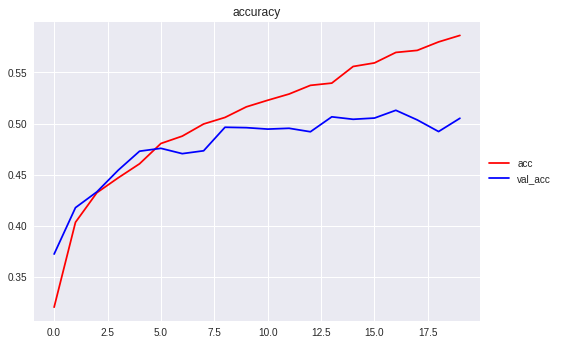

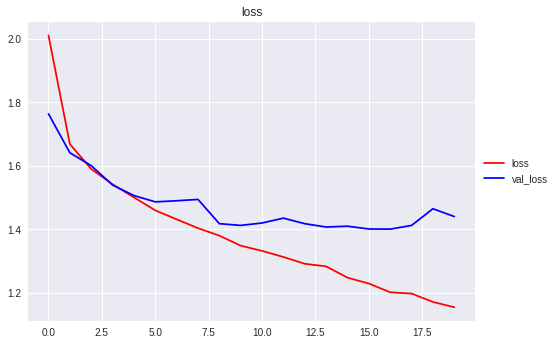

In [18]:
x = range(epochs)
plt.plot(x, history.history['acc'], label='acc', color='r')
plt.plot(x, history.history['val_acc'], label='val_acc', color='b')
# plt.ylim(0.1, 0.3)
plt.title('accuracy')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.plot(x, history.history['loss'], label='loss', color='r')
plt.plot(x, history.history['val_loss'], label='val_loss', color='b')
plt.title('loss')
# plt.ylim(1.5, 2.5)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

* 5 epoch辺りで検証データと差がでてきた -> 過学習
* 5 epochで止めると良い -> Early stopping
* これ以上の精度向上はさらにレイヤー、パラメータ数を増やすのが良いが、簡単に過学習してしまうと思うため、過学習を抑えるテコ入れが必要

### 学習不足、過学習しない良い感じなモデルを探す方法

* 銀の弾はない
* ひたすら叩いて比較して次のパラメータ範囲を決めてアクションし続けるしかないかと
  * 一例
    * 1. 3つモデルを用意。レイヤー数はシンプルに全結合層の3つから始める
    * 2. ①問題に対しこれぐらいは必要だろうと思ったパラメータ数、①より、より大きいパラメータ数を設定、③①と②の間ぐらいのパラメータ数.
    * 3. 上記モデルを学習させて、比較して一番精度の良いモデルを選択
    * 選択したモデルから大小でパラメータを調節するか、レイヤー数を調節するかで次の比較(1 ~ 3)を繰り返し行う
* と、いった流れでやると良いんじゃないかなーと思う
  * 手動でやるのがめんどくさい人はhyperoptとか使うと良いよ
* この場合、時間がかかるので、GPUマシンを使うべし

## 過学習を抑えるためのtips


* 正則化(L2)
  * 正直にいうと使ったこと無い(経験の浅さが垣間見える)
  * 簡単に説明すると、単純なモデルと複雑なモデル２つあったときに、過学習し辛いのは単純なモデルじゃね？
    * じゃあ、単純なモデルって何よ？ -> パラメータの値の分布に関するエントロピーが小さいモデルのこと
    * つまり、ネットワークの重みに小さい値だけが設定されるようにすること
    * 二種類あるけど今回はL2のみ試した
* Dropout
  * 出力特徴量の数を指定した割合分、0に設定する.
     * 8x8の重み(行列)があったとして、dropout(0.5)であれば、50%=8つの値が0に置き換えられる
  * この方法を思いついた元ネタ的な文章をみたが謎
  * とりあえず、指定する確率で0を設定されると、訓練のたびに違うネットワーク -> 違うモデルを学習できるため、ランダムフォレストのようなアンサンブル効果が得られる...らしい
    * (忘れさせるとかよくわからん理解だったけど学習し直す必要がありそう)
* BatchNormalization
  * 入力されたデータをbatch毎にごにょごにょするやつ
  * 過学習を防ぐ効果もあるが、学習が格段に早くなったり、勾配消失問題をなるべく防ぐ効果がある
  
  
これらを比較していく

### L2正則化

Train on 45000 samples, validate on 5000 samples
Epoch 1/20
45000/45000 [==============================] - 15s 341us/step - loss: 3.6377 - acc: 0.3226 - val_loss: 2.1480 - val_acc: 0.3692
Epoch 2/20
45000/45000 [==============================] - 12s 277us/step - loss: 1.9090 - acc: 0.3997 - val_loss: 1.8070 - val_acc: 0.4132
Epoch 3/20
45000/45000 [==============================] - 12s 274us/step - loss: 1.7287 - acc: 0.4203 - val_loss: 1.7102 - val_acc: 0.4210
Epoch 4/20
45000/45000 [==============================] - 13s 278us/step - loss: 1.6459 - acc: 0.4405 - val_loss: 1.6827 - val_acc: 0.4250
Epoch 5/20
45000/45000 [==============================] - 12s 276us/step - loss: 1.6161 - acc: 0.4505 - val_loss: 1.6258 - val_acc: 0.4444
Epoch 6/20
45000/45000 [==============================] - 12s 276us/step - loss: 1.5975 - acc: 0.4591 - val_loss: 1.5971 - val_acc: 0.4564
Epoch 7/20
45000/45000 [==============================] - 12s 276us/step - loss: 1.5796 - acc: 0.4661 - val_loss: 1.5

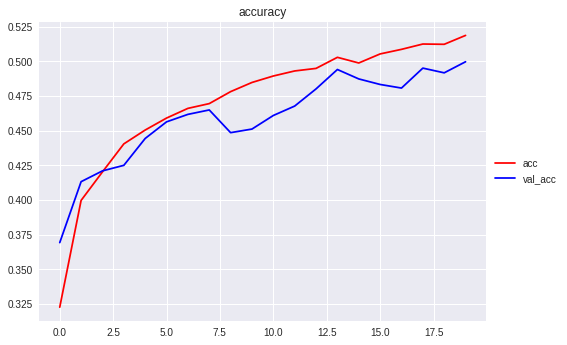

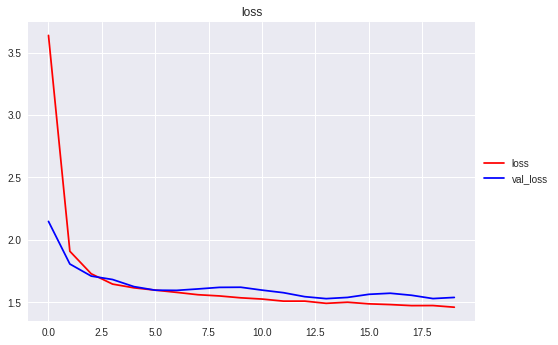

In [26]:
from keras.regularizers import l2


model = Sequential()
model.add(Flatten(input_shape=(32,32,3)))
model.add(Dense(2500, kernel_regularizer=l2(0.001)))
model.add(Activation('relu'))

model.add(Dense(3000, kernel_regularizer=l2(0.001)))
model.add(Activation('relu'))

model.add(Dense(10))
model.add(Activation('softmax'))

model.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])


# モデルのfitting
history = model.fit(X_train,
                    y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_split=0.1)


# テストデータの精度を確認する
loss, acc = model.evaluate(X_test, y_test)
print('test loss: {}, test acc: {}'.format(loss, acc))


x = range(epochs)
plt.plot(x, history.history['acc'], label='acc', color='r')
plt.plot(x, history.history['val_acc'], label='val_acc', color='b')
# plt.ylim(0.1, 0.3)
plt.title('accuracy')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.plot(x, history.history['loss'], label='loss', color='r')
plt.plot(x, history.history['val_loss'], label='val_loss', color='b')
plt.title('loss')
# plt.ylim(1.5, 2.5)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

* 良い感じですね。過学習の参考で出した結果よりよくなっています
* 5 epoch以降で過学習していたのがだいぶ解消されています

### Dropout

Train on 45000 samples, validate on 5000 samples
Epoch 1/20
45000/45000 [==============================] - 12s 274us/step - loss: 2.2396 - acc: 0.2078 - val_loss: 1.9805 - val_acc: 0.2708
Epoch 2/20
45000/45000 [==============================] - 12s 257us/step - loss: 2.0218 - acc: 0.2316 - val_loss: 1.9541 - val_acc: 0.2746
Epoch 3/20
45000/45000 [==============================] - 12s 259us/step - loss: 2.0125 - acc: 0.2354 - val_loss: 1.9652 - val_acc: 0.3012
Epoch 4/20
45000/45000 [==============================] - 12s 259us/step - loss: 1.9925 - acc: 0.2500 - val_loss: 1.9477 - val_acc: 0.3040
Epoch 5/20
45000/45000 [==============================] - 12s 258us/step - loss: 1.9635 - acc: 0.2628 - val_loss: 1.9339 - val_acc: 0.3064
Epoch 6/20
45000/45000 [==============================] - 12s 257us/step - loss: 1.9507 - acc: 0.2737 - val_loss: 1.9260 - val_acc: 0.3216
Epoch 7/20
45000/45000 [==============================] - 12s 257us/step - loss: 1.9426 - acc: 0.2690 - val_loss: 1.9

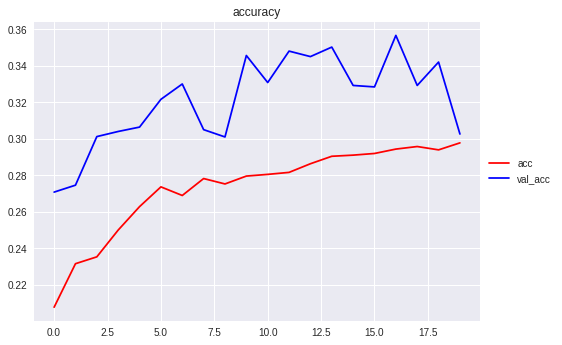

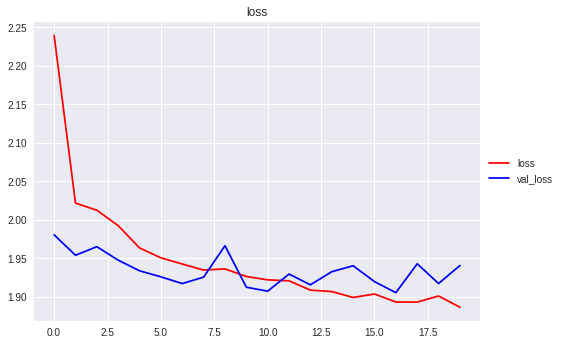

In [29]:
from keras.layers import Dropout



model = Sequential()
model.add(Flatten(input_shape=(32,32,3)))
model.add(Dense(2500))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(3000))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(10))
model.add(Activation('softmax'))

model.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])


# モデルのfitting
history = model.fit(X_train,
                    y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_split=0.1)


# テストデータの精度を確認する
loss, acc = model.evaluate(X_test, y_test)
print('test loss: {}, test acc: {}'.format(loss, acc))


x = range(epochs)
plt.plot(x, history.history['acc'], label='acc', color='r')
plt.plot(x, history.history['val_acc'], label='val_acc', color='b')
# plt.ylim(0.1, 0.3)
plt.title('accuracy')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.plot(x, history.history['loss'], label='loss', color='r')
plt.plot(x, history.history['val_loss'], label='val_loss', color='b')
plt.title('loss')
# plt.ylim(1.5, 2.5)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

* lossは抑えられましたが、精度がいまいち
  * 0.5は忘れ過ぎのようなので~0.4を試して比較すると良い感じのパラメータ指定ができるかも
* 検証データの精度は安定しないが、訓練よりでているので汎化はされている

### BatchNormalization

Train on 45000 samples, validate on 5000 samples
Epoch 1/20
45000/45000 [==============================] - 14s 313us/step - loss: 1.7849 - acc: 0.3950 - val_loss: 2.0457 - val_acc: 0.3284
Epoch 2/20
45000/45000 [==============================] - 13s 282us/step - loss: 1.4953 - acc: 0.4759 - val_loss: 2.0748 - val_acc: 0.3532
Epoch 3/20
45000/45000 [==============================] - 12s 273us/step - loss: 1.3744 - acc: 0.5186 - val_loss: 1.9001 - val_acc: 0.3634
Epoch 4/20
45000/45000 [==============================] - 12s 272us/step - loss: 1.2673 - acc: 0.5532 - val_loss: 2.1767 - val_acc: 0.3294
Epoch 5/20
45000/45000 [==============================] - 12s 272us/step - loss: 1.1680 - acc: 0.5877 - val_loss: 2.2669 - val_acc: 0.3122
Epoch 6/20
45000/45000 [==============================] - 13s 284us/step - loss: 1.0943 - acc: 0.6137 - val_loss: 1.6335 - val_acc: 0.4506
Epoch 7/20
45000/45000 [==============================] - 13s 284us/step - loss: 0.9991 - acc: 0.6438 - val_loss: 1.7

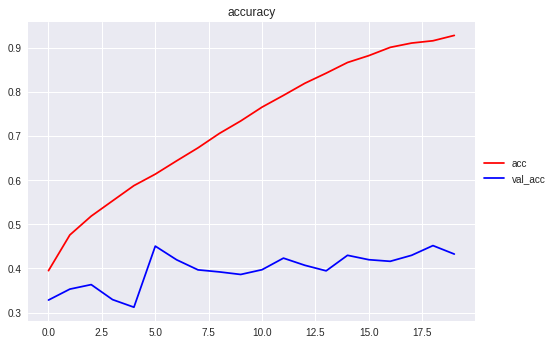

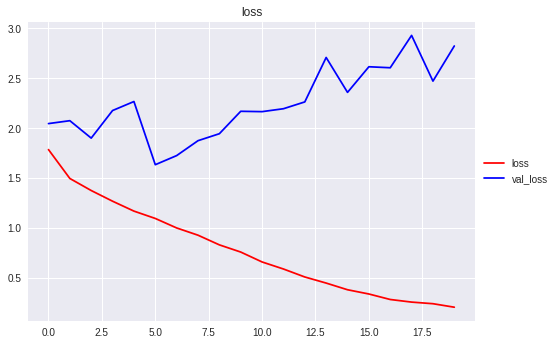

In [30]:
from keras.layers.normalization import BatchNormalization


model = Sequential()
model.add(Flatten(input_shape=(32,32,3)))
model.add(Dense(2500))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Dense(3000))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Dense(10))
model.add(Activation('softmax'))

model.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])


# モデルのfitting
history = model.fit(X_train,
                    y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_split=0.1)


# テストデータの精度を確認する
loss, acc = model.evaluate(X_test, y_test)
print('test loss: {}, test acc: {}'.format(loss, acc))


x = range(epochs)
plt.plot(x, history.history['acc'], label='acc', color='r')
plt.plot(x, history.history['val_acc'], label='val_acc', color='b')
# plt.ylim(0.1, 0.3)
plt.title('accuracy')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.plot(x, history.history['loss'], label='loss', color='r')
plt.plot(x, history.history['val_loss'], label='val_loss', color='b')
plt.title('loss')
# plt.ylim(1.5, 2.5)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

* これがBatchNormalization...!
* みての通り、訓練の学習が(特徴を掴むという意味で)速い
* ただし、だいぶ過学習しているので他方法と組み合わせて抑えるといいと思う

### 比較

In [31]:
a = {'acc': [0.5188, 0.2944, 0.9280],
 'val_acc': [0.4998, 0.3566, 0.4326],
 'loss': [1.4609, 1.8933, 0.2042],
 'val_loss': [1.5391, 1.9054, 2.8242],
 'test_acc': [0.4961, 0.3026, 0.4416],
 'name': ['l2', 'dropout', 'batch_normalization']}
df = pd.DataFrame(a)
df.head()

,acc,loss,name,test_acc,val_acc,val_loss
0,0.5188,1.4609,l2,0.4961,0.4998,1.5391
1,0.2944,1.8933,dropout,0.3026,0.3566,1.9054
2,0.9280,0.2042,batch_normalization,0.4416,0.4326,2.8242


(0, 1.0)

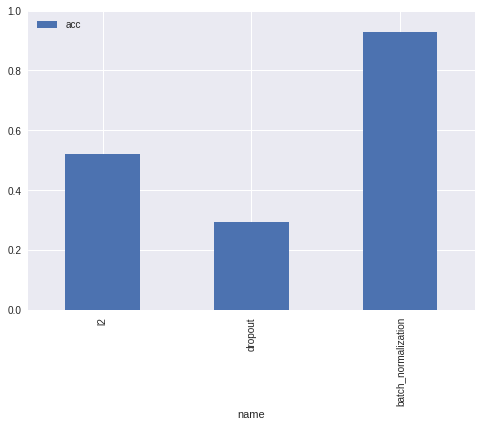

In [35]:
_, ax = plt.subplots()
df[['acc', 'name']].plot.bar(x=['name'], ax=ax)
ax.set_ylim(0, 1.0)

(0, 1.0)

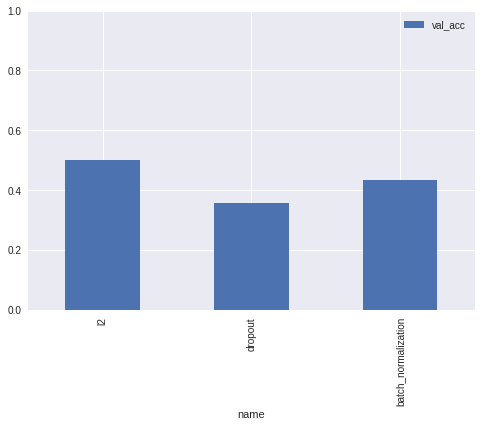

In [37]:
_, ax = plt.subplots()
df[['val_acc', 'name']].plot.bar(x=['name'], ax=ax)
ax.set_ylim(0, 1.0)

(0, 1.0)

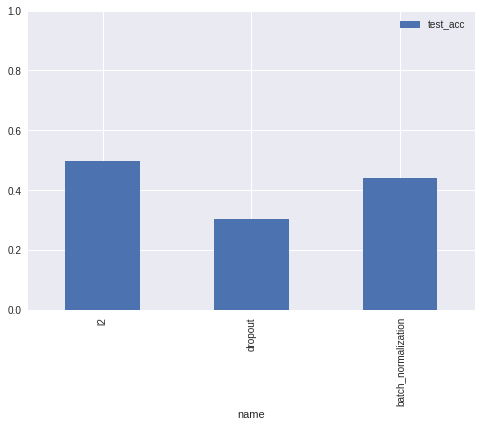

In [36]:
_, ax = plt.subplots()
df[['test_acc', 'name']].plot.bar(x=['name'], ax=ax)
ax.set_ylim(0, 1.0)

* l2とBatchNormalizationの組み合わせが気になるところ
* Dropoutもパラメータ調整したらもっと精度向上できそう